# Pneumothorax Identification from X-Ray Images

By Reynaldo Vazquez<br>
February 2021 

<br>

This notebooks presents my solution to the [SIIM-ACR Pneumothorax Segmentation; Identify Pneumothorax Disease in Chest X-Rays](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation) challenge. The challenge consists on detecting pneumothorax disease (i.e. collapsed lung disease) from x-ray images and masking the location of the disease within the x-ray image. 

<h3> The solution consists on a two-step approach. </h3>

1. The first step is to run the images through an ensemble of binary image neural network classifiers to determine whether the x-ray presents pneumothorax disease. 

2. The second step, runs the image through an ensemble of segmentation neural networks to identify the location of the disease. 

This approach achieves a Dice coefficient of 0.8521 in the offcial private test data of the competition, on par with the top 3% of the results. 

In [ ]:
#@markdown <p>
%%html
<div style = "max-width:950px" align="center">
<iframe src="https://rexvaz.com/files/pneumothorax/carousel.html" width="100%" height="255" 
frameBorder="0"></iframe>
</div>


<h2> Data </h2>

To train using TPUs, I extracted the original data from DICOM files (X-Rays, patient metadata) and CSV files (mask RLE encodings) and placed it in TFRec files. The original DICOM and CSV data can be found [here](). The TFRecs used in this notebook can be found [here](https://www.kaggle.com/reyvaz/siimacr-pneumothorax-segmentation-tfrecs). Note that I changed the type of RLE encoding from relative to absolute initial pixel values, more on this can be found the TFRec dataset description.

<br>
<h2> Training and Evaluation </h2>

All 1st and 2nd step neural networks were trained on a K = 5, K-Fold cross-validation distribution of the data and on different image sizes. Random data augmentations were applied to training partition data for all networks in both stages. Data augmentation was also applied to evaluation data (i.e. out-of-fold and test data) for the 1st step.  

The ensemble for the binary classification step consists of EfficientNet (Tan & Le 2020) based classifiers versions B1-B4. The classifiers were selected according to their out-of-fold (i.e. within fold validation) performance. The metric used for this was accuracy on the full out-of-fold data for each fold. 

Although there’s no official labeled test set for this task, cross-fold and out-of-fold accuracy was >  0.92. Adjustment of the classification thresholds could achieve >  0.99 accuracy, (sensitivity ~ 0.95 and specificity > 0.99) while rendering about a fourth of the results inconclusive. 

The ensemble for the 2nd step consists of Unet (Ronneberger et al., 2015) and Unet Plus Plus (Zhou et al., 2019) based CNNs, all with EfficientNet backbones versions B0-B4. The networks included in the ensemble were selected according to their out-of-fold performance on x-rays with the disease. The metric used here was the average image-wise Dice Coefficient.  The formula to calculate the Dice Coefficient is given by: 

$$
\begin{align*}
\text{Dice Coefficient} = \frac{2|\hat{Y} \cap Y|}{|\hat{Y}| + |Y|}
\end{align*}
$$

where $\hat{Y}$ is the predicted set of pixels and $Y$ is the ground truth.

<br>
<h2> Acknowledgements: <h2>

Thanks to [The Society for Imaging Informatics in Medicine (SIIM)](https://siim.org/) and the [American College of Radiology (ACR)](https://www.acr.org/) for creating and providing the dataset.

<br>
<h2> Running this notebook: </h2>

1. (Required) re-running this notebook requires that the GCS path to the TFRecs be updated. To do so, follow the instructions in this [link]( https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path) and paste the valid GCS path into the `GCS_PATH` variable below. 

2. (Optional) file management can work (AS IS) within Colab’s virtual  environment. However, to save trained weights beyond the current session, specify a path to a connected google drive directory in the `project_dir` variable. 









<h1> Requirements </h1>

In [ ]:
import os, sys, math, re, gc, random
from time import time, strftime, gmtime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
!pip -q install tensorflow_addons >/dev/null
import tensorflow_addons as tfa
tf.get_logger().setLevel('ERROR')

!git clone -q https://github.com/reyvaz/tpu_segmentation.git
!pip install -qr tpu_segmentation/requirements.txt >/dev/null
from tpu_segmentation import *

!wget -q https://raw.githubusercontent.com/reyvaz/pneumothorax_detection/master/pneumothorax_utils.py
from pneumothorax_utils import *

start_notebook = time()
print('Notebook started at: ', current_time_str())
print('Tensorflow version: ', tf.__version__)

Notebook started at:  08:49 AM
Tensorflow version:  2.4.1


<h3> GCS Path </h3>

Follow this [link](https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path) to update GCS Path if needed. 

In [ ]:
GCS_PATH = 'gs://kds-ec66dbb8b29beeafdeb74b4f1add71f88c51dd874698e5359967ee17'
renew_url = 'https://www.kaggle.com/reyvaz/pneumothorax-segmentation-gcs-path'
verify_gcs_path(GCS_PATH, renew_url)

GCS path is valid


<h3> Project directory </h3>

If drive is mounted, `project_dir` can be a path to a directory in drive.


In [ ]:
project_dir = ''

## TPU Distribution Strategy

In [ ]:
#@markdown Detect hardware, return distribution strategy
try: tpu
except:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('TPU not found')
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    else:
        # Default distribution strategy. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.96.65.234:8470


## Constants, File Paths, and K-Fold File Ditribution

**Constants and TFRecs**

In [ ]:
IMAGE_SIZE = [1024, 1024] # original size of the x-ray images
N_CLASSES = 1
N_CHANNELS = 1
N_REPLICAS = strategy.num_replicas_in_sync
classes = ['No Disease', 'Disease']

TFRecs_gcs_path = GCS_PATH + '/tfrecs/'
TFRECS_TRAIN_RLE = tf.io.gfile.glob(TFRecs_gcs_path + '*train-disease*.tfrec')
TFRECS_TRAIN_NORLE = tf.io.gfile.glob(TFRecs_gcs_path + '*train-no-disease*.tfrec')

N_TFRECS_MASK = len(TFRECS_TRAIN_RLE)
N_TFRECS_NOMASK = len(TFRECS_TRAIN_NORLE)

**K-Fold Distribution $(K=5)$**

Fold numbering has base $1$. i.e.  $k \in \{1,2,3,4,5\}$

In [ ]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS)
folds ={}
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(N_TFRECS_MASK))):
    folds.update({fold+1: {'val': idxV, 'train': idxT}})
del fold

def get_fold_file_lists(fold_num, folds=folds, use_unmasked = False):
    fold = folds[fold_num]
    TRAINING_FILENAMES = [TFRECS_TRAIN_RLE[i] for i in fold['train']]
    VALIDATION_FILENAMES = [TFRECS_TRAIN_RLE[i] for i in fold['val']]

    if use_unmasked:
        TRAINING_FILENAMES += [TFRECS_TRAIN_NORLE[i] for i in fold['train']]
        VALIDATION_FILENAMES += [TFRECS_TRAIN_NORLE[i] for i in fold['val']]
    return TRAINING_FILENAMES, VALIDATION_FILENAMES

masked_examples = count_data_items(TFRECS_TRAIN_RLE)
unmasked_examples = count_data_items(TFRECS_TRAIN_NORLE)
class_ratio = unmasked_examples/masked_examples

print('Number of MASKED examples for training and validation:   ', masked_examples)
print('Number of NON MASKED examples for training and validation:', unmasked_examples)

Number of MASKED examples for training and validation:    2669
Number of NON MASKED examples for training and validation: 9378


## Dataset Train Pipeline

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_tfrecord(example, vars = ('image', 'rle', 'label')):
    features = {
        'img_id': tf.io.FixedLenFeature([], tf.string), 
        'image': tf.io.FixedLenFeature([], tf.string), 
        'rle': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        }
    features = {k: features[k] for k in vars}
    example = tf.io.parse_single_example(example, features)
    return [example[var] for var in features]
        
def load_dataset(filenames, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    return dataset.map(read_tfrecord, num_parallel_calls=AUTO)

In [ ]:
undersample_filter = lambda L, P: False if L == 0 and tf.random.uniform([]) < P else True
# randomly filters-out examples with label 0. L is the label, P is the rate to exclude

def decode_resize_inputs(inputs, target_size, image_size = IMAGE_SIZE,
                         n_channels = N_CHANNELS, n_classes = N_CLASSES):
    (image_data, rle), args = inputs[:2], inputs[2:]
    image = tf.image.decode_jpeg(image_data, channels=n_channels)
    image = tf.cast(image, tf.float32) / 255.0  
    mask = build_mask_array(rle, image_size)

    if target_size != image_size:
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size)

    image = tf.reshape(image, [*target_size, n_channels]) 
    mask = tf.reshape(mask, [*target_size, n_classes])
    return (image, mask, *args)

def data_augment(inputs, target_size, 
                 n_channels = N_CHANNELS, n_classes = N_CLASSES, 
                 p1=0.50, p2=0.33, p3=0.33, p4=0.75):
    
    (image, mask, label), args = inputs[:3], inputs[3:]

    if tf.random.uniform([]) < p1:
        image, mask = left_right_flip(image, mask)

    if tf.random.uniform([]) < p2:
        image, mask = random_rotate(image, target_size, n_channels, mask, 
                                    n_classes, 7.)
    elif tf.random.uniform([]) < p2:
        image, mask = random_shear(image, target_size, n_channels, mask)

    if tf.random.uniform([]) < p3: 
        image, mask = random_zoom_out_and_pan(image, target_size, mask, n_channels)
    elif tf.random.uniform([]) < p3*1.5: 
        image, mask = image_mask_zoom_in(image, mask, target_size, label, n_channels)
    
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.7, 1.4)

    if tf.random.uniform([]) < p4: 
        image = coarse_dropout(image, target_size, n_channels, 
                               count_range=(20, 150), m_size = 0.01)
    return (image, mask, label, *args)

def final_reshape(inputs, target_size, target_var, make_rgb, augment,
                  n_channels = N_CHANNELS, n_classes = N_CLASSES):
    '''
    Converts image to 3 channels if specified by `make_rgb`
    Applies augmentations that require 3 channels if requested by `augment`
    Returns the image and one of {mask, label}, as specified by `target_var`
    '''
    (image, mask, label), args = inputs[:3], inputs[3:]

    if make_rgb:
        image = tf.image.grayscale_to_rgb(image)
        n_channels = 3
        if augment:
            image = tf.image.random_hue(image, 0.025)
            image = tf.image.random_saturation(image, 0.6, 1.4)

    image = tf.reshape(image, [*target_size, n_channels]) 

    if target_var == 'mask':
        mask = tf.reshape(mask, [*target_size, n_classes])
        target_var = mask
    elif target_var == 'label': target_var = tf.cast(label, tf.int32)
    else: raise Exception('target_var must be one of \'label\' or \'mask\'')
    return image, target_var

describe_ds = lambda x: print(re.sub('[<>]', '', str(x)))

def print_description(train_ds, val_ds, steps_per_epoch, use_unmasked, 
                      p_undersample, n_train, n_valid):
    describe_ds(train_ds)
    print('Steps per epoch: ', steps_per_epoch)
    approx = 'approx' if p_undersample and p_undersample !=1 and use_unmasked else ''
    print('Num train examples {} {}'.format(n_train, approx))
    print('Num valid examples {}'.format(n_valid))
    return None

In [ ]:
def get_dataset(filenames, target_size, batch_size, target_var = 'mask',
                make_rgb = True, 
                augment = False,
                cache   = False,
                repeat  = False, 
                shuffle = False,
                ordered = False, 
                drop_remainder = False,
                p_undersample = False):
    dataset = load_dataset(filenames, ordered)
    if p_undersample:
        dataset = dataset.filter(lambda *data: undersample_filter(data[2], p_undersample))
    dataset = dataset.map(lambda *data: decode_resize_inputs(data, target_size), AUTO)
    if augment:
        dataset = dataset.map(lambda *data: data_augment(data, target_size), AUTO)
    dataset = dataset.map(lambda *data: final_reshape(data, target_size, 
                                      target_var, make_rgb, augment), AUTO)
    if cache: dataset = dataset.cache()  
    if repeat: dataset = dataset.repeat() 
    if shuffle: dataset = dataset.shuffle(shuffle, reshuffle_each_iteration=True) 
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_datasets(fold_num, target_size, imgs_per_replica, target_var = 'mask',
             use_unmasked = False, p_undersample = False, cache_val = True, print_descr = True):
    TRAINING_FILENAMES, VALIDATION_FILENAMES = get_fold_file_lists(
        fold_num, use_unmasked=use_unmasked)
    
    train_batch_size = imgs_per_replica * N_REPLICAS

    n_train = count_data_items(TRAINING_FILENAMES)
    n_valid = count_data_items(VALIDATION_FILENAMES)

    if p_undersample and use_unmasked and (use_unmasked == True or 'train' in use_unmasked):
        # approx number of examples given random undersampling, val is never undersampled
        n_train = int(n_train * (1-(p_undersample*class_ratio)/(1+class_ratio)))
    else: p_undersample = False
        
    train_steps = np.ceil(n_train/train_batch_size).astype(int)
    buffer_size = int(n_train*0.33)

    random.shuffle(TRAINING_FILENAMES)
    train_dataset = get_dataset(TRAINING_FILENAMES, target_size, train_batch_size, 
                                target_var, 
                                augment = True, 
                                repeat = True, 
                                shuffle = buffer_size,
                                drop_remainder=True, 
                                p_undersample = p_undersample)
    
    val_batch_size = 4 * N_REPLICAS # constant validation dataset batch_size, for metric comparison
    val_steps = np.ceil(n_valid/val_batch_size).astype(int)

    valid_dataset = get_dataset(VALIDATION_FILENAMES, target_size, val_batch_size, target_var, 
                                cache = cache_val, 
                                repeat = True,
                                ordered = True)
    
    if print_descr:
        print_description(train_dataset, valid_dataset, train_steps, 
                          use_unmasked, p_undersample, n_train, n_valid)
    steps = {'train': train_steps, 'valid': val_steps}
    datasets = {'train': train_dataset, 'valid': valid_dataset}
    return datasets, steps

## Data and Augmentations Visualization 

In [ ]:
gen_examples = 10 #@param [10, 20, 50, 100] {type:'raw'}

if gen_examples:
    temp_dataset = get_dataset(TFRECS_TRAIN_RLE[:1], target_size=(512, 512), 
                               batch_size=1)
    data_examples = retrieve_examples(temp_dataset, gen_examples)
    idx = 0

Image and Mask



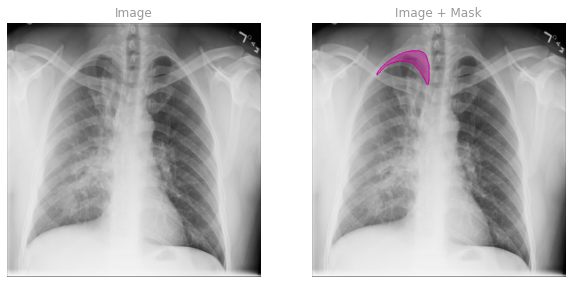



Augmentations



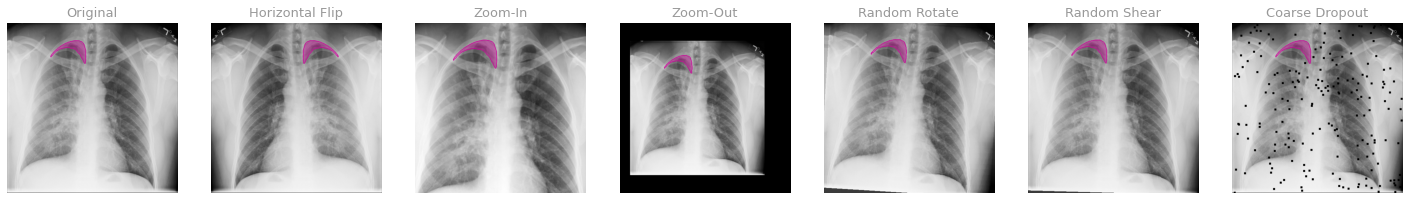

In [ ]:
#@markdown  ← reload to show next example
if gen_examples:
    idx = idx + 1 if idx < gen_examples-1 else 0
    print('Image and Mask\n')
    plot_image_mask(data_examples[idx])

    print('\n\nAugmentations\n')
    show_augmentations(*data_examples[idx])

## Logs and File Organization

In [ ]:
#@markdown Trained Weights Management
weights_dir = project_dir + 'weights/'
!mkdir -p {weights_dir}

# Get names of saved weights (if any) in main weights directory
saved_weights = [w.split('/')[-1] for w in tf.io.gfile.glob(weights_dir+'*.h5')]

weights_metrics = {}
weights_names = {}
for w in saved_weights:
    prefix, sz, _ , metric = w.split('_')
    prefix = '{}_{}'.format(prefix, sz)
    metric_float = float(metric.split('.')[0])*10e-6
    if not prefix in weights_metrics:
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    elif metric_float > weights_metrics[prefix]:
        !mv {weights_dir}{weights_names[prefix]} {weights_dir}discarded/
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    else: 
        !mv {weights_dir}{w} {weights_dir}discarded/

def check_and_save(history, model, fold_num, img_size, metric, metric_abbr = 'acc',
                   current_wname = 'weights.h5', weights_dir=weights_dir):
    current_metric = max(history.history[metric])
    size_str = str(img_size[0]) + 'x' + str(img_size[1])
    prefix = '{}-f{}_{}'.format(model.name.lower(), fold_num, size_str)
    metric_str = str(current_metric*10e4)[:5]
    weights_name = '{}_{}_{}.h5'.format(prefix, metric_abbr, metric_str)
    if not prefix in weights_metrics or current_metric >= weights_metrics[prefix]: 
        weights_names[prefix] = weights_name
        if prefix in weights_metrics:
            !rm -r {weights_dir}{prefix}*
        !cp {current_wname} {weights_dir}{weights_name}
        weights_metrics[prefix] = current_metric
        saved_weights.append(weights_name)
        print('Current weights saved as {}'.format(weights_name))
    return None

def create_df_row(w):
    # w: (str) is the filename of the saved weights
    base, size, _, metric = w.split('_')
    key_id = '{}_{}'.format(base, size)
    metric = float(metric.split('.')[0])*10e-6
    size = eval(size.replace('x', ', '))
    base, efn_ver, model_type, fold_num = base.split('-')
    model_type = model_type.replace('FT', '')
    backbone, fold_num = base+efn_ver, int(fold_num[1])
    return [key_id, backbone, fold_num, size, metric, model_type, w]

def get_best_weights(df, n_per_fold = 5, sort_by_col = 'metric', 
                     group_by_col = 'fold', mode = 'max'):
    m = df.groupby(group_by_col)[sort_by_col]
    m = m.nlargest(n_per_fold) if mode == 'max' else m.nsmallest(n_per_fold)
    try: idxs = [i[1] for i in m.index]
    except: idxs = [i for i in m.index]
    return df.loc[idxs].reset_index(drop=True)

# Binary Classification 

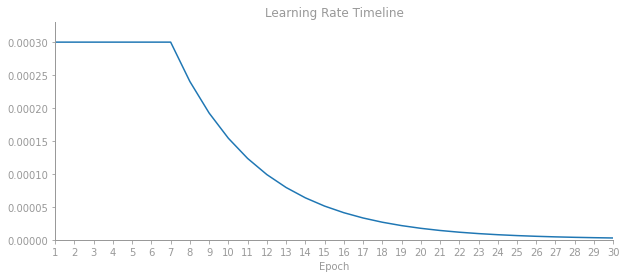

In [ ]:
EPOCHS = 30
imgs_per_replica = 8
use_unmasked = True
p_undersample = 0.50 # rate to exclude x-rays labeled 0

metric_monitor = performance_monitor('val_accuracy', 'max')
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.25)

lr_params =  [3e-4,  3e-4,  1e-6, 2, 4, 8e-1]
lr_sched = lr_schedule_builder(lr_params)
nadam = tf.keras.optimizers.Nadam() 
plot_lr_timeline(lr_params, num_epochs=EPOCHS)

## Training Binary Classifiers

For the sake of brevity, the following loop will only train a couple classifiers for the first fold. More folds can be added to the `folds_to_train` list. 

The loop is set to train squared images, however this is not required, any image size $(H, W)$ can be added as `target_size` . For the segmentation model, this is a bit more restricted as both $H$ and $W$ have to both be divisible by 32 but a 1:1 image ratio is not needed.  

For `efficientnet_versions`, any of the B0-B7 versions can be used but adjustments to the batch size (i.e. `imgs_per_replica`) would have to be done for larger EfficientNet classifiers and larger image sizes to avoid OOM errors. 


In [ ]:
folds_to_train = [1] 
dims_to_train = [512] 
efficientnet_versions = [1, 2]

for training_fold in folds_to_train:
    for dim in dims_to_train: 
        target_size = (dim, dim)
        print(hline)
        cache_val, imgs_per_replica = (True, 8) if dim <= 512 else (False, 4)
        datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica , 
                            'label', use_unmasked, p_undersample, cache_val)
        INPUT_SHAPE  = (*target_size, 3)
        for efn_ver in efficientnet_versions:
            base_model = 'EfficientNet-B{}'.format(efn_ver)
            print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                    base_model, training_fold, target_size) + hline)
            
            with strategy.scope():                       
                model = build_classifier(base_model, N_CLASSES, INPUT_SHAPE, 
                                            name_suffix='-bin')
                model.compile(optimizer=nadam, loss=loss, metrics=['accuracy', 'AUC']) 

            checkpoint = config_checkpoint(monitor ='val_accuracy', mode = 'max')
            train_begin = time()

            history = model.fit(datasets['train'], steps_per_epoch=steps['train'],
                    epochs = EPOCHS,
                    verbose = 0, 
                    callbacks=[lr_sched, metric_monitor, checkpoint],
                    validation_data = datasets['valid'], validation_steps = steps['valid'])
            
            check_and_save(history, model, training_fold, target_size, 'val_accuracy')
            print('Time to train {} epochs: {} (mm:ss)\n'.format(
                EPOCHS, time_passed(train_begin)))
            
            del model
            K.clear_session()

del training_fold, dim, target_size, datasets, INPUT_SHAPE, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((64, 512, 512, 3), (64,)), types: (tf.float32, tf.int32)
Steps per epoch:  92
Num train examples 5884 approx
Num valid examples 2412
───────────────────────────────────────────────────────────────────────────────────
Training EfficientNet-B1 on FOLD 1 with image size (512, 512)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_accuracy improved from -inf to 0.8470
New best at Epoch 004 val_accuracy improved from 0.8470 to 0.8655
New best at Epoch 005 val_accuracy improved from 0.8655 to 0.8873
New best at Epoch 008 val_accuracy improved from 0.8873 to 0.8997
New best at Epoch 010 val_accuracy improved from 0.8997 to 0.9046
New best at Epoch 012 val_accuracy improved from 0.9046 to 0.9120

Best at Epoch: 012 loss: 0.44870 accuracy: 0.93274 auc: 0.97914 val_loss: 0.47579 val_accuracy: 0.91201 val_auc: 0.95206
Time to trai

## Binary Evaluation
For this print-out, the following evaluation selects from the weights trained above and from existing trained weights in a connected drive. When a drive is not connected, evaluation will use the weights temporarily stored during the current training. 

The evaluation below corresponds to the fold 1 partition of the data. To perform evaluation corresponding to any of the other folds (if already trained), specify the `fold_num` variable below. 


In [ ]:
#@markdown Load Trained Model, Assemble Ensemble Functions
!mkdir -p ./weights 

def load_pretrained_model(weights_id, compile_model = True, opt = [], 
                          loss = 'default', metrics = 'default', details = []):
    
    prefix, size = weights_id.split('_')
    size = eval(size.replace('x', ', '))
    base, base_ver, model_type, _  = prefix.split('-')
    wname = weights_names[weights_id]
    weights_path = weights_dir + wname

    # Import weights to colab (if elsewhere) to avoid "bad symbol" errors
    if not os.path.isfile('./weights/' + wname):
        !cp {weights_path} ./weights/{wname}
    weights_path = './weights/' + wname

    base_name = base + base_ver

    if 'bin' in model_type: builder = build_classifier
    elif 'unetpp' in model_type: builder = xnet
    elif 'unet' in model_type: builder = unet

    if compile_model:
        if 'bin' in model_type:
            if metrics == 'default': metrics = ['accuracy', 'AUC']
            if loss == 'default': loss = 'binary_crossentropy'
        elif 'unet' in model_type:
            if metrics == 'default': metrics = [dice_coef, dice_avg]
            if loss == 'default': loss = [bce_dice_loss]
        
    with strategy.scope():
        model = builder(base_name, 1, input_shape=(*size, 3), weights = None)
        model.load_weights(weights_path)
        if compile_model:
            model.compile(optimizer=opt, loss=loss, metrics=metrics)
            
    if len(details) > 0: 
        scope = locals()
        return (model, *[eval(d, scope) for d in details])
    else: return model

def determine_outter_size(weights_keys):
    sizes = [eval(k.split('_')[-1].replace('x', ', ')) for k in weights_keys]
    areas = [s[0]*s[1] for s in sizes]
    return sizes[np.argmax(areas)]

def assemble_ensemble(weights_ids, outter_size = 'auto', ensemble_type = 'auto', 
                      metrics = 'default', loss = 'default', details = []):
    if outter_size == 'auto': outter_size = determine_outter_size(weights_ids)
    if ensemble_type == 'auto': 
        ensemble_type = 'segmentation' if 'unet' in weights_ids[0] else 'binary'

    ensemble_outputs = []
    resized_inputs = {}
    with strategy.scope():
        x = L.Input(shape=(*outter_size, 3))
        for i, w in enumerate(weights_ids):
            model, size = load_pretrained_model(w, compile_model = False, details = ['size'])
            model._name = '{}-M{}'.format(model.name, i)
            if size == outter_size:
                model_output = model(x)
            else:
                if not str(size) in resized_inputs: 
                    resized_inputs[str(size)] = tf.image.resize(x, size)
                model_output = model(resized_inputs[str(size)])
                if ensemble_type == 'segmentation':
                    model_output = tf.image.resize(model_output, outter_size)

            ensemble_outputs.append(model_output)

        y = L.Average(name = 'Simple_Average')(ensemble_outputs)

        if metrics == 'default':
            if ensemble_type == 'segmentation': metrics = [dice_coef, dice_avg] 
            else: metrics = ['accuracy', 'AUC']

        if loss == 'default':
            if ensemble_type == 'segmentation': loss = [bce_dice_loss]
            else: loss = 'binary_crossentropy'

        name = '{}_Ensemble'.format(ensemble_type.title())
        ensemble = tf.keras.Model(inputs=x, outputs=y, name=name)
        ensemble.compile(optimizer=[], loss=loss, metrics=metrics)
    
    if len(details) > 0: 
        scope = locals()
        return (ensemble, *[eval(d, scope) for d in details])
    else: return ensemble

eval_temp_fix = lambda model, ds: model.evaluate(ds, steps = 1, verbose = 0)[3:]
# current TF version has a documented issue in which the first evaluation after 
# using model.load_weights() is not accurate. This "fix" circumvents the issue.

In [ ]:
#@markdown Evaluation Datasets
def data_meta(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(lambda x: read_tfrecord(x, vars = ('img_id', 'label', 'rle')), 
                          num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

def get_eval_datasets(fold_num, target_size = (256, 256), target_var = 'mask', 
                      imgs_per_replica = 8, augment = False, repeat = False):
    '''
    Returns Datasets for evaluation, they are ordered, do not drop remainder. 
    Augmentations and Repeat if requested. 
    '''
    batch_size = imgs_per_replica * N_REPLICAS
    tfrec_lists = get_fold_file_lists(fold_num, use_unmasked = True)
    create_ds = lambda fnames: get_dataset(fnames, target_size, batch_size, target_var, 
                                           augment = augment, repeat = repeat, ordered = True)
    keys = 'train', 'valid'
    datasets = {k: create_ds(tfrec_lists[i]) for i, k in enumerate(keys)}
    counts = {k: count_data_items(tfrec_lists[i]) for i, k in enumerate(keys)}
    min_steps = {k: np.ceil(counts[k]/batch_size).astype(int) for k in counts }
    meta_datasets = {k: data_meta(tfrec_lists[i]) for i, k in enumerate(keys)}
    return datasets, counts, min_steps, meta_datasets

<h4> Build Metadata from TFRecs 

(i.e. Image IDs, Labels, RLEs)

In [ ]:
fold_num = 1
_, counts, steps, meta_dsets = get_eval_datasets(fold_num)

start_retrive_meta = time()
meta_list = []
for item in meta_dsets['valid']:
    meta_list.append([i.numpy() for i in item])

meta_df = pd.DataFrame(meta_list, columns = ['ImageId', 'label', 'rle'])
del meta_list
print('Time to build metadata from tfrecs: {}'.format(time_passed(start_retrive_meta)))

Time to build metadata from tfrecs: 00:13


<h4> Gather Best and Ensemble Classifiers Info for Binary Classification

In [ ]:
col_names = ['key', 'base', 'fold', 'size', 'accuracy', 'model_type', 'filename']
bin_df_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
bin_df = pd.DataFrame(bin_df_rows, columns = col_names)

n_top = 4 # i.e. fold-wise ensemble size
best_bin = get_best_weights(bin_df, n_top, 'accuracy')

best_bin_fold = best_bin[best_bin.fold==fold_num]
bin_keys = best_bin_fold.key.values

display(best_bin_fold[col_names[1:6]])

,base,fold,size,accuracy,model_type
0,efficientnetb3,1,"(1024, 1024)",0.92105,bin
1,efficientnetb2,1,"(1024, 1024)",0.91873,bin
2,efficientnetb4,1,"(512, 512)",0.91776,bin
3,efficientnetb4,1,"(1024, 1024)",0.91708,bin


### tf.keras Evaluation
Quick evaluation using `model.evaluate()`. Use repeated dataset and specify steps so that results can be compared between augmented and not augmented data. 

Evaluate single best classifier

In [ ]:
model, size = load_pretrained_model(bin_keys[0], details = ['size'])
dsets_repeat = get_eval_datasets(fold_num, size, 'label', repeat = True)[0]
dsets_aug = get_eval_datasets(fold_num, size, 'label', repeat = True, augment = True)[0]
eval_temp_fix(model, dsets_repeat['valid'])

print('\nEvaluating on un-augmented validation data')
_ = model.evaluate(dsets_repeat['valid'], steps = steps['valid'])

print('\nEvaluating on un-augmented train data')
_ = model.evaluate(dsets_repeat['train'], steps = steps['train'])

del model; 
K.clear_session()


Evaluating on un-augmented validation data
38/38 [==============================] - 20s 489ms/step - loss: 0.2731 - accuracy: 0.9206 - auc: 0.9514

Evaluating on un-augmented train data
151/151 [==============================] - 75s 484ms/step - loss: 0.1699 - accuracy: 0.9831 - auc: 0.9980


Evaluate ensemble of best classifiers (i.e. with highest out-of-fold accuracy)

In [ ]:
binary_ensemble, outter_size = assemble_ensemble(bin_keys, details = ['outter_size'])

if outter_size != size:
    dsets_repeat = get_eval_datasets(fold_num, outter_size, 'label', repeat = True)[0]
    dsets_aug = get_eval_datasets(fold_num, outter_size, 'label', repeat = True, augment = True)[0]

eval_temp_fix(binary_ensemble, dsets_repeat['valid'])
binary_ensemble.summary()

Model: "Binary_Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
tf.image.resize (TFOpLambda)    (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B3-M0 (Functional) (None, 1)            10785065    input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B2-M1 (Functional) (None, 1)            7769971     input_1[0][0]                    
____________________________________________________________________________________

In [ ]:
# this will likely evaluate more augmentation steps than needed but will make 
# evaluation comparable with non-augmented evaluation
n_TTA = 5 # number of test time augmentations for evaluation

print('\nEvaluating on un-augmented validation data')
_ = binary_ensemble.evaluate(dsets_repeat['valid'], steps = steps['valid'])

print('\nEvaluating on augmented validation data')
_ = binary_ensemble.evaluate(dsets_aug['valid'], steps = steps['valid']*n_TTA)


Evaluating on un-augmented validation data
38/38 [==============================] - 39s 981ms/step - loss: 0.2596 - accuracy: 0.9239 - auc: 0.9664

Evaluating on augmented validation data
190/190 [==============================] - 261s 1s/step - loss: 0.2561 - accuracy: 0.9271 - auc: 0.9673


During testing it was observed that the ensemble model consistently outperformed the single best performing classifier; it typically increased accuracy by about 0.3 percent and AUC by about 1.3 percent. 

Random test-time augmentations generally improved accuracy by about 0.4 percent on the ensemble model. 

### Predict + Evaluate

In [ ]:
n_TTA = 5
batch_size = [len(i[0]) for i in dsets_aug['valid'].take(1)][0] 
n_preds_needed = n_TTA*counts['valid']
tta_steps = np.ceil(n_preds_needed/batch_size).astype(int)

In [ ]:
preds = binary_ensemble.predict(dsets_aug['valid'], steps = tta_steps, verbose=1)
preds = preds[:n_preds_needed,]
preds = preds.reshape((counts['valid'], n_TTA), order='F')

preds_prob = np.mean(preds, axis = 1)
meta_df['preds_prob'] = preds_prob

del binary_ensemble

189/189 [==============================] - 299s 2s/step


### Performance Report for Full Validation Dataset

The following evaluates classification performance using a cut-off at 0.50. All images are assigned a label.

Report from Total Results

Accuracy:          93.03%
Sensitivity:       0.832
Specificity:       0.958

Total obs:         2412
True Positives:    446
True Negatives:    1798
False Positives:   78
False Negatives:   90



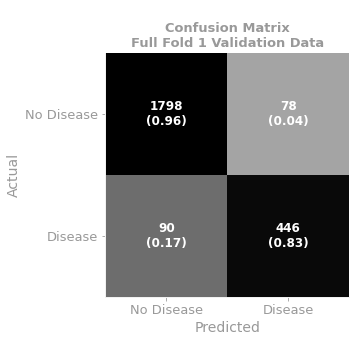


Number of incorrect predictions (validation): 168, out of 2412 total


In [ ]:
preds_df = performance_report(meta_df, preds_col = 'preds_prob', report_type = 'total')

gt_labels, pred_labels = preds_df.label, preds_df.preds_round
cm = confusion_matrix(gt_labels, pred_labels)
cm_plot(cm=cm, labels = classes, p_size = 5,  cmap = plt.cm.Greys,
        subtitle = 'Full Fold {} Validation Data'.format(fold_num))

incorrect = np.where(gt_labels != pred_labels)[0]
print('\nNumber of incorrect predictions (validation): {}, out of {} total'.format(
    incorrect.shape[0], counts['valid']))

### Performance Report for High Confidence Predictions in Validation Data

This section experiments by assigning high confidence thresholds for the labeling of the x-rays. The model is able to achieve about ~0.99 accuracy and specificity, and ~0.95 sensitivity on about 75% percent of the images. 

The biggest weakness for the model is in its sensitivity, which most certainly is the most crucial objective of model for missing the presence of the disease would be the most dangerous. 

During post-prediction analysis, it was noted that for positive cases the confidence at detecting the disease was positively correlated with the area indicating the disease in the image. So long as such area would be of medical significance (i.e. larger area, more medical urgency), the model would be better at detecting the most urgent cases of the disease. This could potentially assist at the prioritization of cases when medical resources are more scarce. 


Report from High Confidence Results

Accuracy:          99.02%
Sensitivity:       0.949
Specificity:       0.997

Total obs:         2412
Predicted:         1839
Inconclusive:      573
Rate Inconclusive: 23.76%
True Positives:    260
True Negatives:    1561
False Positives:   4
False Negatives:   14



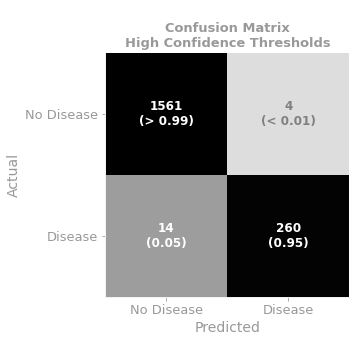


18 out of 1839 validation predictions were incorrect. 573 out of 2412 were inconclusive.


In [ ]:
neg_thresh = 0.18
pos_thresh = 0.80
high_conf_df = performance_report(meta_df, 'preds_prob', neg_thresh, pos_thresh, 
                           report_type = 'high_confidence')

gt_labels, pred_labels = high_conf_df.label, high_conf_df.preds_round
cm = confusion_matrix(gt_labels, pred_labels)
cm_plot(cm=cm, labels = classes, p_size = 5, cmap = plt.cm.Greys, 
        subtitle = 'High Confidence Thresholds')

incorrect = np.where(gt_labels != pred_labels)[0]
print('\n{} out of {} validation predictions were incorrect. {} out of {} were inconclusive.'.format(
    incorrect.shape[0], len(gt_labels), counts['valid']-len(gt_labels), counts['valid']))

Report from High Confidence Results

Accuracy:          99.11%
Sensitivity:       0.956
Specificity:       0.997

Total obs:         2412
Predicted:         1803
Inconclusive:      609
Rate Inconclusive: 25.25%
True Positives:    260
True Negatives:    1527
False Positives:   4
False Negatives:   12



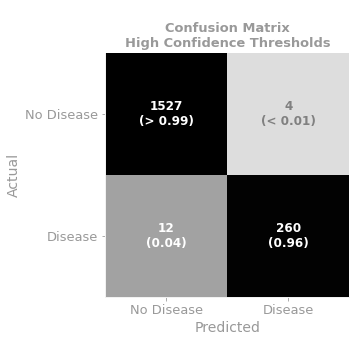


16 out of 1803 validation predictions were incorrect. 609 out of 2412 were inconclusive.


In [ ]:
neg_thresh = 0.17
pos_thresh = 0.80
high_conf_df = performance_report(meta_df, 'preds_prob', neg_thresh, pos_thresh, 
                           report_type = 'high_confidence')

gt_labels, pred_labels = high_conf_df.label, high_conf_df.preds_round
cm = confusion_matrix(gt_labels, pred_labels)
cm_plot(cm=cm, labels = classes, p_size = 5, cmap = plt.cm.Greys, 
        subtitle = 'High Confidence Thresholds')

incorrect = np.where(gt_labels != pred_labels)[0]
print('\n{} out of {} validation predictions were incorrect. {} out of {} were inconclusive.'.format(
    incorrect.shape[0], len(gt_labels), counts['valid']-len(gt_labels), counts['valid']))

# Mask Segmentation

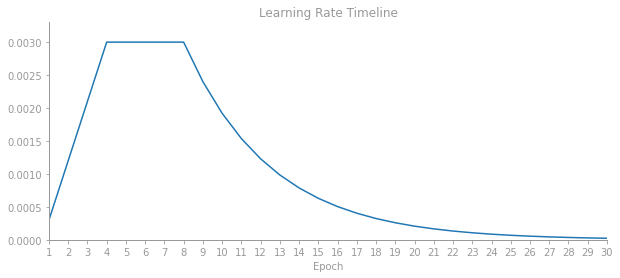

In [ ]:
EPOCHS = 30
imgs_per_replica = 4
metric_monitor = performance_monitor('val_dice_coef', 'max')

lr_params =  [3e-4,  3e-3,  1e-6, 3, 4, 8e-1] 
lr_sched = lr_schedule_builder(lr_params)

radam = tfa.optimizers.RectifiedAdam()  
plot_lr_timeline(lr_params, num_epochs=EPOCHS)

### Training Segmentation Ensemble

The following loop will train 1 Unet and 1 Unet Plus Plus networks for the first fold. To train on other folds simply add them to the `folds_to_train` list. 

The loop is set to train squared images, however this is not required, any image size $(H, W)$ can be added as `target_size`  as long as both $H$ and $W$ are divisible by 32. 

For `efficientnet_versions`, any of the B0-B7 versions can be used to build the Unet and Unet Plus Plus networks, however, I did not test training on networks with backbones larger than EfficientNetB5. Adjustments to the batch size would have to be done for larger EfficientNet backbones and larger image sizes to avoid OOM errors.


In [ ]:
folds_to_train = [1] 
dims_to_train = [480] 
efficientnet_versions = [3]
seg_models = [unet, xnet]

for training_fold in folds_to_train:
    for dim in dims_to_train: 
        target_size = (dim, dim)
        print(hline)
        datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 
                                    cache_val = False)
        INPUT_SHAPE  = (*target_size, 3)
        for seg_model in seg_models:
            for efn_ver in efficientnet_versions:
                backbone_name = 'EfficientNet-B{}'.format(efn_ver)
                with strategy.scope():
                    model = seg_model(backbone_name, N_CLASSES, INPUT_SHAPE)
                    model.compile(optimizer=radam, loss=bce_dice_loss, 
                                metrics=[dice_coef, dice_avg]) 

                print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                                    model.name, training_fold, target_size) + hline)

                checkpoint = config_checkpoint(monitor ='val_dice_avg', mode = 'max')
                train_begin = time()
                history = model.fit(datasets['train'], steps_per_epoch=steps['train'], 
                                epochs = EPOCHS,
                                verbose = 0, 
                                callbacks=[lr_sched, metric_monitor, checkpoint],
                                validation_data=datasets['valid'], validation_steps = steps['valid'])

                check_and_save(history, model, training_fold, target_size, 'val_dice_avg', 'adice')
                print('Time to train {} epochs: {} (mm:ss)\n'.format(
                    EPOCHS, time_passed(train_begin)))
                del model
                K.clear_session()

del training_fold, dim, target_size, datasets, INPUT_SHAPE, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((32, 480, 480, 3), (32, 480, 480, 1)), types: (tf.float32, tf.float32)
Steps per epoch:  67
Num train examples 2133 
Num valid examples 536
───────────────────────────────────────────────────────────────────────────────────
Training Efficientnet-B3-Unet on FOLD 1 with image size (480, 480)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_dice_coef improved from -inf to 0.0261
New best at Epoch 002 val_dice_coef improved from 0.0261 to 0.0973
New best at Epoch 003 val_dice_coef improved from 0.0973 to 0.1623
New best at Epoch 006 val_dice_coef improved from 0.1623 to 0.3405
New best at Epoch 007 val_dice_coef improved from 0.3405 to 0.4239
New best at Epoch 009 val_dice_coef improved from 0.4239 to 0.4984
New best at Epoch 010 val_dice_coef improved from 0.4984 to 0.5750
New best at Epoch 011 val_dice_coef improved from

## Evaluating Mask Predictions

The evaluation below corresponds to the partition of the data corresponding to the fold used in the Binary Evaluation. Note that data created in that step is needed for evaluating the mask predictions below. Specifically, metadata and binary prediction data from the `meta_df` dataframe is needed in the mask prediction evaluation loop. 

<h4> Gather Mask Segmentation Ensemble Info

In [ ]:
seg_df_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 
col_names[4] = 'avg_dice'
seg_df = pd.DataFrame(seg_df_rows, columns = col_names)

n_top = 4
best_seg = get_best_weights(seg_df, n_top, 'avg_dice')
best_seg_fold = best_seg[best_seg.fold==fold_num]
seg_keys = best_seg_fold.key.values
display(best_seg_fold[col_names[1:6]])

,base,fold,size,avg_dice,model_type
0,efficientnetb3,1,"(544, 544)",0.56986,unet
1,efficientnetb4,1,"(544, 544)",0.56634,unet
2,efficientnetb1,1,"(512, 512)",0.56146,unetpp
3,efficientnetb4,1,"(480, 480)",0.55737,unetpp


<h4> Build Mask Segmentation Ensemble

In [ ]:
segmentation_ensemble, outter_size = assemble_ensemble(seg_keys, details = ['outter_size'])

n_parts = 3
dsets, counts, steps, _ = get_eval_datasets(fold_num, outter_size, 'mask')
valid_ds_parts = split_dataset(dsets['valid'], steps['valid'], n_parts = n_parts)

segmentation_ensemble.summary()

Model: "Segmentation_Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 544, 544, 3) 0                                            
__________________________________________________________________________________________________
tf.image.resize (TFOpLambda)    (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.image.resize_2 (TFOpLambda)  (None, 480, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Efficientnet-B1-UnetPP-M2 (Func (None, 512, 512, 1)  16013857    tf.image.resize[0][0]            
______________________________________________________________________________

### Mask Prediction Evaluation on Full Validation Dataset using Dice Coefficient

In [ ]:
meta_dict = meta_df.to_dict()
dice_eval = lambda y, p: dice_coef(tf.cast(y, tf.float32), tf.cast(p, tf.float32))
empty_mask = np.zeros(outter_size, int) 

Mask Prediction Evaluation Loop

This will calculate the average dice coefficient over the entire out-of-fold data corresponding to Fold 1. Unlike the dice coefficient used during training, which excluded images labeled as "no disease", this calculation includes both types of x-rays. Thus, this calculation produces the metric which is more relevant to the official challenge. 

In [ ]:
# Post-processing parameters
binary_treshhold = 0.60
thresh_upper = 0.75
thresh_lower = 0.40
min_area   = 200 

# Save some predictions for demo
demo_preds = [] 
n_demo =  100

dices = []

i = 0
start_preds = time()
for p, ds_part in enumerate(valid_ds_parts): 
    print('Predicting and processing part {} of {}'.format(p+1, n_parts))
    preds = segmentation_ensemble.predict(ds_part, verbose = 1)
    preds = np.squeeze(preds)
    gt_masks = [m.numpy().squeeze() for m in ds_part.map(lambda x, y: y).unbatch()]
    print('Shape of predictions part {}: {}\n'.format(p+1, preds.shape))
    for gt_mask, pred in zip(gt_masks, preds):
        instance_id = meta_dict['ImageId'][i]
        if meta_dict['preds_prob'][i]  > binary_treshhold:
            pred_ = pred.copy()
            pred  = (pred > thresh_upper).astype(int)
            if pred.sum() < min_area: pred_mask = empty_mask
            else: 
                pred_mask = (pred_ > thresh_lower).astype(int)
                if len(demo_preds) < n_demo:
                    demo_preds.append([i, gt_mask, pred_mask])
        else: pred_mask = empty_mask
        dices.append(dice_eval(gt_mask, pred_mask).numpy())
        i += 1
    del preds, gt_masks

print('Elapsed time {}'.format(time_passed(start_preds)))
print('Mean Dice:', np.mean(dices))

Predicting and processing part 1 of 3
13/13 [==============================] - 93s 2s/step
Shape of predictions part 1: (832, 544, 544)

Predicting and processing part 2 of 3
13/13 [==============================] - 27s 2s/step
Shape of predictions part 2: (832, 544, 544)

Predicting and processing part 3 of 3
12/12 [==============================] - 26s 2s/step
Shape of predictions part 3: (748, 544, 544)

Elapsed time 04:25
Mean Dice: 0.87118363


## Mask Prediction Examples

In [ ]:
#@markdown Plot Mask Ground Truth vs. Prediction
def plot_mask_gt_vs_prediction(pred_demo):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    rgb_colors = {'Ground Truth': (200, 0, 150),
                  'Prediction':   (0, 51, 204)}

    for c, (key, rgb_color) in enumerate(rgb_colors.items()):
        ax = fig.axes[c]
        ax.imshow(pred_demo[0], cmap=plt.cm.bone)
        ax.imshow(contoured_mask(pred_demo[c+1], rgb_color = rgb_color, alpha = 0.2))
        ax.axis('off')
        ax.set_title(key, fontdict={'fontsize': 13})
    plt.show()
    return None

In [ ]:
ds_part_0 = valid_ds_parts[0].map(lambda x, y: x).unbatch()
masked_idxs = [p[0] for p in demo_preds]
imgs = []
for i, img in enumerate(ds_part_0):
    if i in masked_idxs: 
        imgs.append(img)
        if len(imgs) == n_demo: break

demo_tuples = [(imgs[i], d[1], d[2]) for i, d in enumerate(demo_preds)]

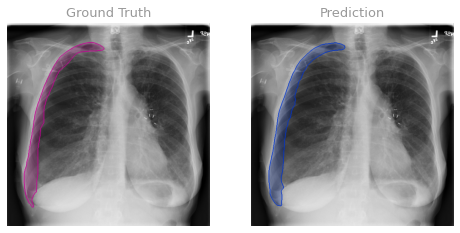

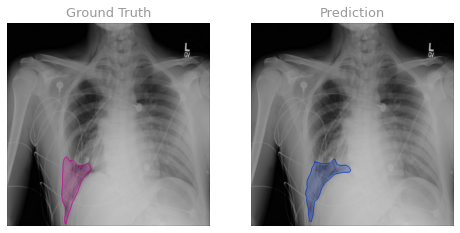

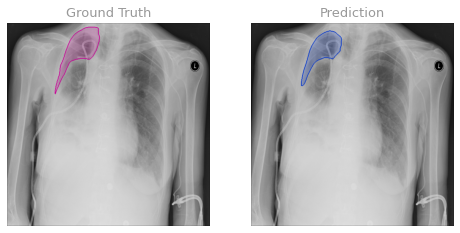

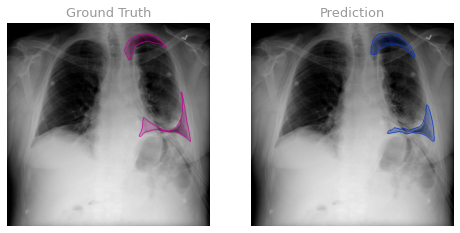

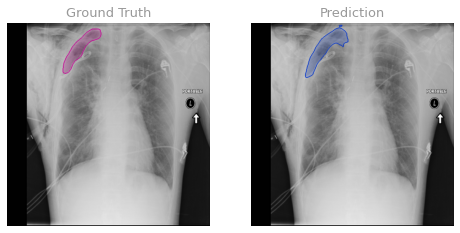

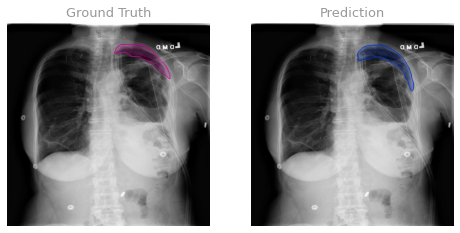

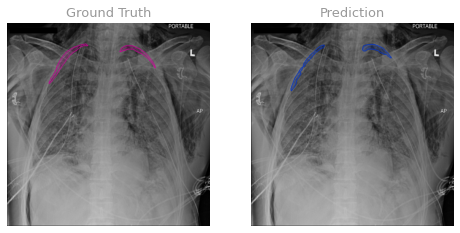

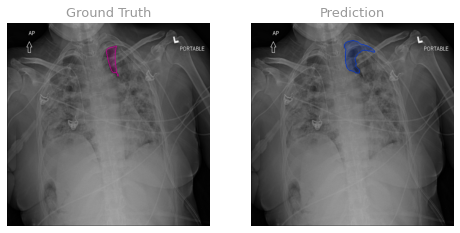

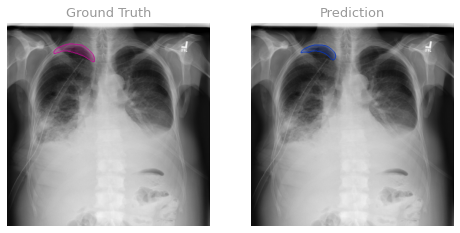

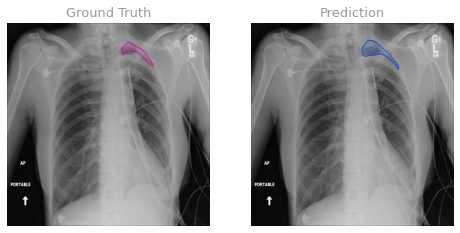

In [ ]:
for i in np.random.choice(n_demo, 10, replace=False):
    plot_mask_gt_vs_prediction(demo_tuples[i])
    print('\n')

In [ ]:
#@markdown Runtime
print('Time to run notebook: ', time_passed(start_notebook))
print('Notebook finished at:', current_time_str())

Time to run notebook:  01:36:38
Notebook finished at: 10:26 AM


# **References**:

- Tan, M., & Le, Q. V. (2020). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.

- Ronneberger O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation.

- Zhou, Z., Siddiquee, M., Tajbakhsh, N., & Liang, J. (2019). UNet++: Redesigning Skip Connections to Exploit Multiscale Features in Image Segmentation IEEE - Transactions on Medical Imaging.